<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Aiport-data" data-toc-modified-id="Aiport-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Aiport data</a></span></li><li><span><a href="#Get-all-weather-data-..." data-toc-modified-id="Get-all-weather-data-...-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get all weather data ...</a></span></li><li><span><a href="#...-and-extract-weather-close-to-airports" data-toc-modified-id="...-and-extract-weather-close-to-airports-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>... and extract weather close to airports</a></span></li><li><span><a href="#Weather-patterns" data-toc-modified-id="Weather-patterns-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Weather patterns</a></span></li><li><span><a href="#Correlations-from-top-10-pairs" data-toc-modified-id="Correlations-from-top-10-pairs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Correlations from top 10 pairs</a></span></li></ul></div>

# Aiport data

Combine airport codes and top airports into a table with relevant info (name, wikipedia link, latitude, longitute).

In [1]:
import pandas as pd

# load top 50 airports
top50 = pd.read_csv("hw_5_data/top_airports.csv")
top50_mini = top50[["ICAO", "Airport"]]

# load aiport info
codes = pd.read_csv("hw_5_data/ICAO_airports.csv")
codes_mini = codes[["ident", "latitude_deg", "longitude_deg", "wikipedia_link"]]
codes_mini = codes_mini.rename(columns={'ident': "ICAO"})

# combine data into one table
data = pd.merge(top50_mini, codes_mini, how="left", on="ICAO")

Load this table into a database.

In [ ]:
from sqlalchemy import *

# initiate engine
engine = create_engine("sqlite:///airport_info.db")

# convert pd to list
data.to_sql(name='airports', con=engine)


# Get all weather data ... 
# ... and extract weather close to airports

Get historical weather information (min/max temperature, relative humidity, perciptation) for 1990-2000 from dataset used in class (with xarray/netCDF4).

In [135]:
# load weather data!

import xarray as xr
# temp: tasmax/tasmin, RH: rhsmax/rhsmin, precipitation: pr

datatypes = ["tasmax", "tasmin", "rhsmax", "rhsmin", "pr"]
datatypes_str = ["air_temperature", "air_temperature", "relative_humidity", "relative_humidity", "precipitation"]
datatypes_nice = ["air_temperature_max", "air_temperature_min", "relative_humidity_max", "relative_humidity_min", "precipitation"]

storage = []
for i in range(len(datatypes)):
    
    data_path = ("http://thredds.northwestknowledge.net:8080/"
                 f"thredds/dodsC/agg_macav2metdata_{datatypes[i]}"
                 "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc"
                )
    storage.append(xr.open_dataset(data_path).rename({datatypes_str[i] : datatypes_nice[i]}))


# combine all data types
weather_data = xr.merge(storage)

# reduce to time window of interest
time_window = pd.date_range(start='1/1/1990', end='12/31/2000', freq='D')
weather_data = weather_data.sel(time=time_window)

Just keep weather data for coordinates closest to each aiport.

In [137]:
# for each airport, find closest (long, lat) in weather data

import numpy as np


def find_closest(weather_long, weather_lat, this_long, this_lat):
    """
    Find the closest weather station to aiport longitude and 
    latitude coordinates.
    
    Parameters
    ----------
    weather_long : np array
        Vector of floats with longitude coordinates for all weather stations
    weather_lat : np array
        Vector of floats with latitude coordinates for all weather stations
    this_long : float
        Longitude coordinate for this airport
    this_lat : float
        Latitude coordinate for this airport
        
    Returns
    -------
    idx : int
        Index for closest weather station
        
    """
    # convert weather long coordinates to match expected for aiport
    weather_long_adjusted = weather_long - 360
    
    # find closest long idx:
    long_idx = np.abs(weather_long_adjusted - this_long).argmin()
    
    # find closest lat idx:
    lat_idx = np.abs(weather_lat - this_lat).argmin()
    
    return long_idx, lat_idx

# extract all of the long, lat coordinates from the weather data
weather_long = max_temp_xr["air_temperature"]["lon"].values
weather_lat = max_temp_xr["air_temperature"]["lat"].values

# extract all of the airport long, lat coordinates 
airport_long = engine.execute("SELECT longitude_deg FROM airports").fetchall()
airport_lat = engine.execute("SELECT latitude_deg FROM airports").fetchall()

# get airport names
airport_ICAO = engine.execute("SELECT ICAO FROM airports").fetchall()

# identify the closest weather station for each airport
weather_idx = [find_closest(weather_long, weather_lat, airport_long[i][0], airport_lat[i][0]) 
               for i in range(len(airport_long))] # (long, lat)

In [184]:
# pull out weather data closest to each airport and concat into a new xarray
storage = []

for i in range(len(airport_ICAO)):
    port_data = weather_data.sel(lon=weather_long[weather_idx[i][0]], 
                                 lat=weather_lat[weather_idx[i][1]])
    storage.append(port_data.assign_coords({"airport_ICAO": airport_ICAO[i][0]}).drop(["lon","lat","crs"]))

airport_weather = xr.concat(storage, "airport_ICAO", coords="different") 

KeyboardInterrupt: 

This method is pretty slow... there has to be a better way to flatten the weather (long, lat) and select the coordinates I want without concatinating all of these new xarrays.

# Weather patterns

# Correlations from top 10 pairs

# (code playground)

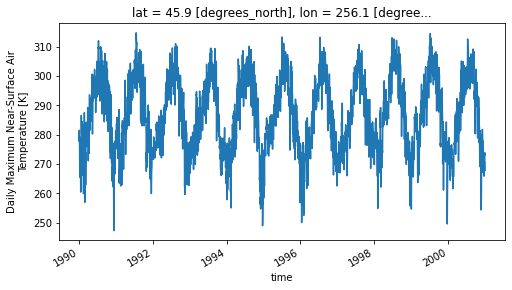

In [9]:
import matplotlib.pyplot as plt


key=500

longitude = max_temp_xr["air_temperature"]["lon"].values[key]
latitude = max_temp_xr["air_temperature"]["lat"].values[key]

# lat = engine.execute("SELECT latitude_deg FROM airports").fetchall()
# long = engine.execute("SELECT longitude_deg FROM airports").fetchall()
time_window = pd.date_range(start='1/1/1990', end='12/31/2000', freq='D')
one_point = max_temp_xr["air_temperature"].sel(lat=latitude,
                                               lon=longitude,
                                            time=time_window)
one_point
plt.figure(figsize=(8,4))
one_point.plot()

In [11]:
longitude = max_temp_xr["air_temperature"]["lon"].values
plt.hist(longitude-360)

(array([59., 58., 59., 58., 59., 58., 58., 59., 58., 59.]),
 array([25.06307793, 27.49637241, 29.9296669 , 32.36296139, 34.79625587,
        37.22955036, 39.66284485, 42.09613934, 44.52943382, 46.96272831,
        49.3960228 ]),
 <BarContainer object of 10 artists>)

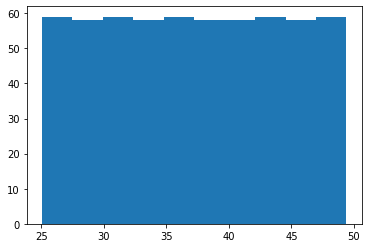

In [20]:
latitude = max_temp_xr["air_temperature"]["lat"].values
plt.hist(latitude)

In [13]:
plt.hist(long)

1

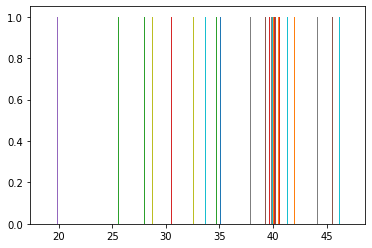

In [21]:
lat = engine.execute("SELECT latitude_deg FROM airports").fetchall()
plt.hist(lat)
1

In [ ]:
def find_closest_coord(long_all, long_0):
    
    return np.abs(long_all - long_0).argmin()

In [ ]:
long_all = max_temp_xr["air_temperature"]["lon"].values
long_0 = lat[0]

In [ ]:
find_closest_coord(long_all, long_0)


In [ ]:
np.abs(long_all - long_0).argmin()

In [ ]:
# engine.execute("SELECT * FROM airports").fetchall()




In [ ]:
max_temp_xr["air_temperature"]["lon"].values[1:3]

In [ ]:
longitude = max_temp_xr["air_temperature"]["lon"].values[:3]
latitude = max_temp_xr["air_temperature"]["lat"].values[:3]